Source for KNN implementation: https://github.com/turnerluke/ML-algos/blob/main/knn/KNeighborsClassifier.py



In [1]:
import numpy as np
import timeit
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from ipywidgets import interact
import seaborn as sns
import random
from scipy import stats as st
from scipy.spatial.distance import cdist
import statistics as st

%matplotlib inline

In [2]:
from MyPCA import *

In [5]:
# import MNIST dataset (might take a few seconds)

from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True, parser = 'auto')

# check the datatype and shape of the data
print(type(images), images.shape)
print(type(labels), labels.shape)

# if not in NumPy, convert the data to NumPy array

images = np.array(images)
labels = np.array(labels)

# check the shape of an individual image sample
print(type(images[0]), images[0].shape)
print(type(labels[0]), labels[0])

# select 1000 samples from the whole MNIST dataset
num_datapoints = 1000
# some preprocessing
X = (images.reshape(-1, 28*28)[:num_datapoints])/ 255 
# dividing by 255 will scale pixel values between [0, 1]
y = labels.astype(float) #convert string labels to float
y = y[:num_datapoints]

<class 'pandas.core.frame.DataFrame'> (70000, 784)
<class 'pandas.core.series.Series'> (70000,)
<class 'numpy.ndarray'> (784,)
<class 'str'> 5


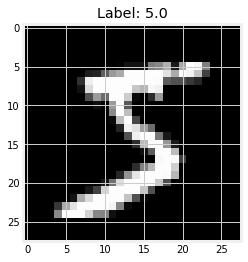

In [6]:
# plot an image
def image_plotter(X, labels, ix):
    plt.figure(figsize = (4, 4))
    plt.imshow(X[ix].reshape(28, 28), cmap = 'gray')
    plt.title('Label: '+ str(labels[ix]))
    
image_plotter(X, y, 0)

In [7]:
samples_len = 100 #100 examples each of class '0' and class '1' are taken from dataset, leading to a collection of 100 images
classes = [7, 1]
y_2classes = np.concatenate([y[y==classes[0]][:samples_len], y[y==classes[1]][:samples_len]])
X_2classes = np.concatenate([X[y==classes[0]][:samples_len], X[y==classes[1]][:samples_len]])

print(X_2classes.shape, y_2classes.shape)

(200, 784) (200,)


In [8]:
y_2classes[y_2classes == 7].shape

(100,)

index:  71 Label:  7.0


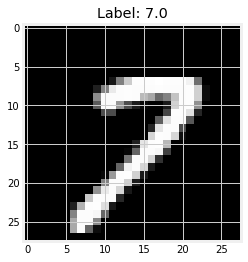

In [9]:
ix_l = np.random.randint(0, len(X_2classes))
print("index: ", ix_l, "Label: ", y_2classes[ix_l])
image_plotter(X_2classes, y_2classes, ix_l)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_2classes, y_2classes, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape)

(134, 784) (66, 784)


In [11]:
mypca = MyPCA(10)
mypca.fit(X) #we provide mu and std to enforce mypca to use the given statistics
z = mypca.transform(X)
#print(z.shape)

reconst = mypca.inverse_transform(z)
#print(reconst.shape)
total_expl_variance_ratio = np.sum(mypca.explained_variance())
print("total explained variance ratio: ", total_expl_variance_ratio.round(4))

total explained variance ratio:  0.3439


## k-nearest neighbours classification

The k-nearest neighbors (k-NN) classification algorithm is a type of instance-based learning, where the function is only approximated locally and all computation is deferred until classification.

Given a new data point $x$, the algorithm finds the $k$ training examples that are closest to it in terms of distance, and then predicts the output based on the outputs of these $k$ neighbors. Let $N_k(x)$ be the set of $k$ nearest neighbors of $x$, and let $y_i$ be the output of the $i$-th nearest neighbor. The predicted output $\hat{y}$ is given by:

$$
\hat{y} = \text{mode}\{y_i : x_i \in N_k(x)\}
$$

where $\text{mode}\{.\}$ is the mode function that returns the most common value among its arguments.

The distance between two data points can be measured using various distance metrics, such as Euclidean distance, Manhattan distance, or Minkowski distance. The choice of distance metric depends on the problem at hand.

In summary, k-nearest neighbors classification works by finding the $k$ nearest neighbors of a new data point and predicting the output based on the most common output among these neighbors.


Some definitions:

1. *Instance based learning*: it makes predictions based on the specific instances of the training data, rather than constructing a general model that captures the underlying relationship between the input and output variables.

2. *Function is only approximated locally*: the prediction for a new data point is based on the outputs of its k nearest neighbors in the training data. This is in contrast to other machine learning algorithms, such as linear regression or decision trees, where a global model is constructed to approximate the function over the entire input space.

In [12]:
help(plot_mnist_pca)

Help on function plot_mnist_pca in module MyPCA:

plot_mnist_pca(X, y, n_components=2)



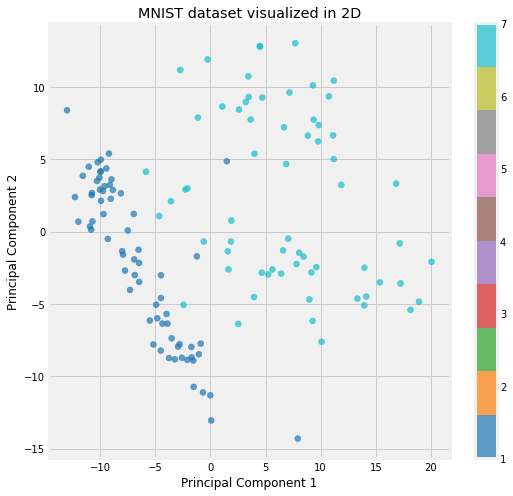

In [13]:
plot_mnist_pca(X_train, y_train, 2)

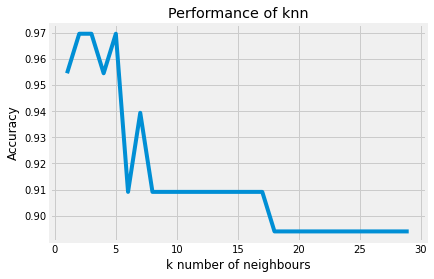

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def most_common(lst):
    return max(set(lst), key=lst.count)

def euclidean(point, data):
    # Euclidean distance between points a & data
    return np.sqrt(np.sum((point - data)**2, axis=1))

class KNeighborsClassifier:
    def __init__(self, k=5, dist_metric=euclidean):
        self.k = k
        self.dist_metric = dist_metric

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        neighbors = []
        for x in X_test:
            distances = self.dist_metric(x, self.X_train)
            y_sorted = [y for _, y in sorted(zip(distances, self.y_train))]
            neighbors.append(y_sorted[:self.k])

        return list(map(most_common, neighbors))

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = sum(y_pred == y_test) / len(y_test)
        return accuracy


# Preprocess data
mypca = MyPCA(50)
mypca.fit(X_train)
X_train_reduced = mypca.transform(X_train)
X_test_reduced = mypca.transform(X_test)

# Test knn model across varying ks
accuracies = []
ks = range(1, 30)
for k in ks:
    knn = KNeighborsClassifier(k=k)
    knn.fit(X_train_reduced, y_train)
    accuracy = knn.evaluate(X_test_reduced, y_test)
    accuracies.append(accuracy)

# Visualize accuracy vs. k
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k number of neighbours",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()


In [166]:
# Example parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'n_components': [10, 20, 30, 40, 50]
}

In [16]:
param_combos = []
    
for n_neighbor in param_grid['n_neighbors']:
    for n_component in param_grid['n_components']:
        
        param_combo = {
            'n_neighbors': n_neighbor,
            'n_components': n_component
        }
        param_combos.append(param_combo)

In [17]:
len(param_combos)

25

In [155]:
def k_fold_split(X, y, k=5):
    """Splits data into k folds for cross-validation"""
    fold_size = len(X) // k
    indices = np.arange(len(X))
    #np.random.shuffle(indices)
    
    folds = []
    for i in range(k):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.setdiff1d(indices, val_indices)
        folds.append((train_indices, val_indices))
    
    return folds


from tqdm import tqdm

def grid_search_cv(X, y, param_grid, k_folds = 5, model = 'kmeans', centroids = None):
    
    best_score = -np.inf
    best_params = None
    
    param_combinations = []
    
    if model == 'knn':
    
        for n_neighbor in param_grid['n_neighbors']:
            for n_component in param_grid['n_components']:
        
                param_combo = {
                    'n_neighbors': n_neighbor,
                    'n_components': n_component
                }
                param_combinations.append(param_combo)
                
                
    elif model == 'kmeans':
        
        for n_clusters in param_grid['n_clusters']:
            for n_component in param_grid['n_components']:
                
                param_combo = {
                    'n_clusters': n_clusters,
                    'n_components': n_component
                }
                param_combinations.append(param_combo)                
    
    folds = k_fold_split(X, y, k = k_folds)
    
    with tqdm(total=len(param_combinations) * k_folds, desc='Grid Search') as pbar:
        for params in param_combinations: 
            cv_scores = []
        
            for train_indices, val_indices in folds: 
                X_train, X_val = X[train_indices], X[val_indices]
                y_train, y_val = y[train_indices], y[val_indices]
            
                #apply PCA
                mypca = MyPCA(params['n_components'])
                mypca.fit(X_train)
                X_train_pca = mypca.transform(X_train)
                X_val_pca = mypca.transform(X_val)
            
                #train with KNN
                if model == 'knn':
                
                    knn = KNeighborsClassifier(k = params['n_neighbors'])
                    knn.fit(X_train_pca, y_train)
            
                    #validate model
                    #y_val_pred = knn.predict(X_val_pca)
                    accuracy = knn.evaluate(X_val_pca, y_val)
                    cv_scores.append(accuracy)
                
                elif model == 'kmeans':
                    
                    kmeans = KMeans(n_clusters = params['n_clusters'])
                    kmeans.fit(X_train_pca)
                    
                    #validate model
                    y_val_pred = kmeans.predict(X_val_pca)
                    accuracy = np.mean(y_val_pred == y_val)
                    cv_scores.append(accuracy)
                
                pbar.update(1)
                
            mean_cv_score = np.mean(cv_scores)
        
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_params = params
    
    return best_params, best_score

In [156]:
# Example parameter grid
param_grid = {
    'n_neighbors': [5, 7, 9, 11],
    'n_components': [10, 20, 30]
}

best_params, best_score = grid_search_cv(X_train, y_train, param_grid, k_folds = 5, model = 'knn')

print("Best Parameters: ", best_params)
print("Best Cross-Validation Accuracy: {:.2f}".format(best_score))

Grid Search: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:14<00:00,  4.11it/s]

Best Parameters:  {'n_neighbors': 5, 'n_components': 10}
Best Cross-Validation Accuracy: 0.96


In [158]:
# Preprocess data
mypca = MyPCA(10)
mypca.fit(X_train)
X_train_reduced = mypca.transform(X_train)
X_test_reduced = mypca.transform(X_test)


knn_best = KNeighborsClassifier(k = 5)
knn_best.fit(X_train_reduced, y_train)

test_accuracy = knn_best.evaluate(X_test_reduced, y_test)

print(test_accuracy)

0.9848484848484849


## K-means clustering

### Unsupervised learning

Unsupervised learning, also known as unsupervised machine learning, uses machine learning algorithms to analyze and cluster unlabeled datasets. These algorithms discover hidden patterns or data groupings without the need for human intervention. Its ability to discover similarities and differences in information make it the ideal solution for exploratory data analysis, cross-selling strategies, customer segmentation, and image recognition. 

[source](https://www.ibm.com/topics/unsupervised-learning)

There is no specific $y$ variable, hence there is no clear ***correct*** answer.

An example of this class of problem is:

1. You are working for a T-shirt designing company. Your task is to narrow down the sizes of the T-shirts. The T-shirt has 2 variables - length and width. You have collected data from potential buyers. You have their length and width. These data points are however scattered, and you need to decide on 3 particular sizes(S, M and L).

### How would you go about solving this problem?

The k-means clustering algorithm works by iteratively performing 2 steps:

Step 1. assigning each data point to one of k clusters based on the distance between the data point and the cluster’s centroid

Step 2. updating the centroid of each cluster based on the mean of the data points assigned to it.

#### Defining it more clearly

Let $x_1, x_2, ..., x_n$ be the $n$ data points, and let $c_1, c_2, ..., c_k$ be the centroids of the $k$ clusters. The objective of k-means clustering is to minimize the within-cluster sum of squares (WCSS), which is given by:

$$
\sum_{i=1}^k \sum_{x \in c_i} ||x - \mu_i||^2
$$

where $\mu_i$ is the mean of the data points in cluster $c_i$.

The k-means clustering algorithm works by iteratively assigning each data point to the cluster with the nearest centroid and then updating the centroid of each cluster based on the mean of the data points assigned to it. The algorithm terminates when the assignments no longer change.

The assignment step can be expressed mathematically as:

$$
c_i = \{x : ||x - \mu_i|| \leq ||x - \mu_j|| \text{ for all } 1 \leq j \leq k\}
$$

The update step can be expressed mathematically as:

$$
\mu_i = \frac{1}{|c_i|} \sum_{x \in c_i} x
$$

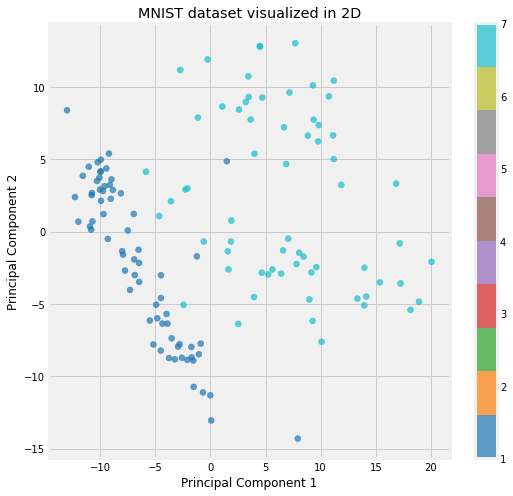

In [21]:
plot_mnist_pca(X_train, y_train, 2)

In [97]:
# Preprocess data
mypca = MyPCA(2)
mypca.fit(X_train)
X_train_reduced = mypca.transform(X_train)
X_test_reduced = mypca.transform(X_test)
y_train_encoded = y_train.copy()
y_train_encoded[y_train == 7] = 0

In [159]:
class KMeans:
    def __init__(self, n_clusters, centroids = None, max_iter=300, tol=1e-6):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = centroids

    def fit(self, X):
        n_samples, n_features = X.shape
        
        
        if self.centroids == None:
        # Randomly initialize the centroids as k random samples from X
            #random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
            random_indices = np.arange(0, self.n_clusters, 1)
            self.centroids = X[random_indices]


        for _ in range(self.max_iter):
            # Assign clusters based on the closest centroid
            distances = self._compute_distances(X)
            self.labels_ = np.argmin(distances, axis=1)

            # Compute new centroids
            new_centroids = np.array([X[self.labels_ == i].mean(axis=0) for i in range(self.n_clusters)])
            
            # Check for convergence
            if np.all(np.abs(new_centroids - self.centroids) <= self.tol):
                break
            
            self.centroids = new_centroids

    def predict(self, X):
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)

    def _compute_distances(self, X):
        return np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)



In [162]:
param_grid_kmeans = {
    'n_clusters': [2],
    'n_components': [10, 50, 200]
}

# Perform grid search CV for KMeans
best_params_kmeans, best_score_kmeans = grid_search_cv(X_train, y_train_encoded, param_grid_kmeans, centroids = None, k_folds=5, model='kmeans')
print("Best KMeans Parameters: ", best_params_kmeans)
print("Best KMeans Cross-Validation Accuracy: {:.2f}".format(best_score_kmeans))

Grid Search: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  4.14it/s]

Best KMeans Parameters:  {'n_clusters': 2, 'n_components': 50}
Best KMeans Cross-Validation Accuracy: 0.74


In [164]:
# Preprocess data
mypca = MyPCA(50)
mypca.fit(X_train)
X_train_reduced = mypca.transform(X_train)
X_test_reduced = mypca.transform(X_test)


kmeans_best = KMeans(n_clusters = 2)
kmeans_best.fit(X_train_reduced)
y_test_pred = kmeans_best.predict(X_test_reduced)
y_test_pred[y_test_pred == 0] = 7
test_accuracy_Kmeans = np.mean(y_test_pred == y_test)



print(test_accuracy_Kmeans)

0.9545454545454546
